In [1]:
!pip install tensorflow
!pip install keras
!pip install pydot
!pip install pydotplus
!pip install graphviz

import nltk

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('words')
nltk.download('averaged_perceptron_tagger')

  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/93/21/9b035a4f823d6aee2917c75415be9a95861ff3d73a0a65e48edbf210cec1/tensorflow-2.15.0-cp311-cp311-win_amd64.whl.metadata
  Using cached tensorflow-2.15.0-cp311-cp311-win_amd64.whl.metadata (3.6 kB)
  Obtaining dependency information for tensorflow-intel==2.15.0 from https://files.pythonhosted.org/packages/4c/48/1a5a15517f18eaa4ff8d598b1c000300b20c1bb0e624539d702117a0c369/tensorflow_intel-2.15.0-cp311-cp311-win_amd64.whl.metadata
  Using cached tensorflow_intel-2.15.0-cp311-cp311-win_amd64.whl.metadata (5.1 kB)
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/01/e4/dc0a1dcc4e74e08d7abedab278c795eef54a224363bb18f5692f416d834f/absl_py-2.0.0-py3-none-any.whl.metadata
  Using cached absl_py-2.0.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Obtaining dependency information for flatbuffers>=23.5.26


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: D:\Python311\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: D:\Python311\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: D:\Python311\python.exe -m pip install --upgrade pip


  Using cached pydotplus-2.0.2-py3-none-any.whl



[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: D:\Python311\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: D:\Python311\python.exe -m pip install --upgrade pip


  Using cached graphviz-0.20.1-py3-none-any.whl (47 kB)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vmshi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vmshi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\vmshi\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\vmshi\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
# Load the required libraries
import nltk

import keras
import pandas as pd
import re
import string

from keras.preprocessing.text import Tokenizer

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB

import visualkeras

#### Custom functions ####
# Remove proper nouns
def remove_proper(data):
    tagged_sentence = nltk.tag.pos_tag(data.split())
    edited_sentence = [word for word, tag in tagged_sentence if tag != "NNP" and tag != "NNPS"]
    edited_sentence = ' '.join(edited_sentence)
    return edited_sentence

# Remove non-English words
def remove_nonEnglish(data):
    words = set(nltk.corpus.words.words())
    original_sentence = data.split()
    edited_sentence = [word for word in original_sentence if word in words]
    edited_sentence = ' '.join(edited_sentence)
    return edited_sentence

# Remove stop words
def remove_stopWords(data):
    stop_words = set(stopwords.words('english'))
    original_sentence = data.split()
    edited_sentence = [word for word in original_sentence if word not in stop_words]
    edited_sentence = ' '.join(edited_sentence)
    return edited_sentence

# Grab n-grams
def extract_ngrams(data, num):
    n_grams = ngrams(word_tokenize(data), num)
    return n_grams

# Plot training and validation metrics
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.axhline(y = 0.85, linestyle = "--")
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

# Create word embeddings for the datasets
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(vector, dtype = np.float32)[:embedding_dim]
    
    return embedding_matrix

In [134]:
# Import the training and validation data, clean it, and split it into training and validation datasets
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.sequence import pad_sequences
lemma = WordNetLemmatizer()
    
annotations = pd.read_csv("../data/sentenceData.csv", encoding='cp1252')
annotations = annotations[annotations['class'].notnull()]

# Pre-processing, remove non-English words, remove proper nouns, remove non-alphanumeric characters
annotations['sentence'] = annotations['sentence'].apply(lambda x: remove_nonEnglish(x))
annotations['sentence'] = annotations['sentence'].apply(lambda x: remove_proper(x))
# annotations['sentence'] = annotations['sentence'].apply(lambda x: remove_stopWords(x))
annotations['sentence'] = annotations['sentence'].apply(lambda x: re.sub(r'[0-9]','', x))
annotations['sentence'] = annotations['sentence'].apply(lambda x: x.lower())

# Split the data into training and validation datasets
sentences_train, sentences_test, y_train, y_test = train_test_split(annotations['sentence'], annotations['class'],
                                                                    test_size = 0.20, random_state=756)
tokenizer = Tokenizer(num_words = 8000)
tokenizer.fit_on_texts(sentences_train)
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

X_train = pad_sequences(X_train, padding="post", maxlen=250)
X_test = pad_sequences(X_test, padding="post", maxlen=250)

In [135]:
# Create the word embeddings matrix and get summary statistics
word_embeddings = create_embedding_matrix('../data/glove.6B.300d.txt', tokenizer.word_index, 300)
nonzero_elements = np.count_nonzero(np.count_nonzero(word_embeddings, axis = 1))

# Cast the labels to a numpy array
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [136]:
nonzero_elements / (len(tokenizer.word_index) + 1)

0.9972862957937585

In [153]:
# Create a neural network to operate on the embeddings
model = keras.Sequential()
model.add(keras.layers.Embedding((len(tokenizer.word_index) + 1),
                                 300, weights=[word_embeddings],
                                 input_length = 250,
                                 trainable = False))
model.add(keras.layers.Conv1D(16, 5, activation = "elu"))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(16, activation = "elu", activity_regularizer=keras.regularizers.L1(0.0001)))
model.add(keras.layers.Dense(3, activation="softmax"))

opt = keras.optimizers.Adam(learning_rate = 0.0005)
callback = keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 4)
callbacks = [callback]

class_weights = {0: 1,
                 1: 1,
                 2: 0.66}

model.compile(optimizer=opt,
              loss="categorical_crossentropy",
              metrics = ['accuracy', keras.metrics.Recall(), keras.metrics.Precision()])
model.summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_41 (Embedding)    (None, 250, 300)          221100    
                                                                 
 conv1d_83 (Conv1D)          (None, 246, 16)           24016     
                                                                 
 global_average_pooling1d_4  (None, 16)                0         
 0 (GlobalAveragePooling1D)                                      
                                                                 
 dropout_38 (Dropout)        (None, 16)                0         
                                                                 
 dense_78 (Dense)            (None, 16)                272       
                                                                 
 dense_79 (Dense)            (None, 3)                 51        
                                                     

In [154]:
history = model.fit(X_train, y_train,
                    epochs = 500,
                    verbose = False,
                    validation_data = (X_test, y_test),
                    batch_size = 12, class_weight=class_weights,
                    callbacks=callback)

loss, accuracy, recall, precision = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
print("Training Recall: {:.4f}".format(recall))

loss, accuracy, recall, precision = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
print("Testing Recall:  {:.4f}".format(recall))

Training Accuracy: 0.9852
Training Recall: 0.9803
Testing Accuracy:  0.8431
Testing Recall:  0.8235


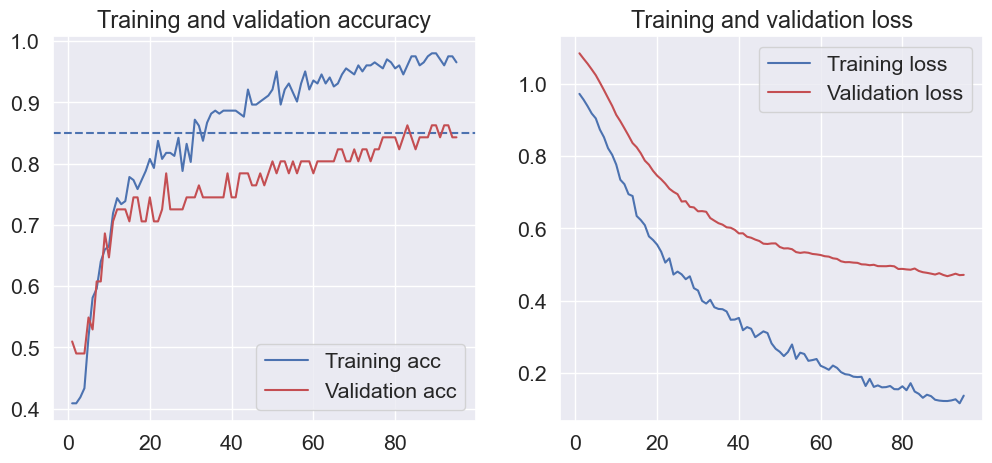

In [155]:
plot_history(history)

2/2 [==============================] - 0s 3ms/step


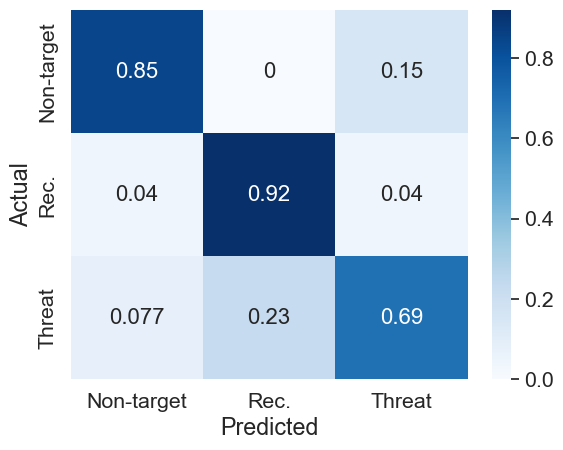

In [164]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)
y_test_x = np.argmax(y_test, axis = 1)

result = confusion_matrix(y_test_x, y_pred, normalize = "true")

from matplotlib.patches import Rectangle

import seaborn as sn
df_cm = pd.DataFrame(result, range(3), range(3))
sn.set(font_scale = 1.4)
g = sn.heatmap(df_cm, annot=True, annot_kws={'size':16}, cmap="Blues")
# g.add_patch(Rectangle((0,1), 1, 2, fill=False, edgecolor='red', lw=1))
g.set_xticklabels(['Non-target', 'Rec.', 'Threat'])
g.set_yticklabels(['Non-target', 'Rec.', 'Threat'])
g.set(xlabel = "Predicted", ylabel = "Actual")
plt.show()